In [52]:
import geopandas as gpd
import contextily
import ibis

from streetscapes.sources import SourceType
from streetscapes.streetview import SVWorkspace


ibis.options.interactive = True

In [53]:
ws = SVWorkspace("./Amsterdam", create=True)
mp = ws.add_source(SourceType.Mapillary)

gss = ws.add_source(SourceType.GlobalStreetscapes)
gss.show_contents()

datasets--NUS-UAL--global-streetscapes/
├─info.csv
├─data/
│ └─parquet/
│   └─streetscapes.parquet
└─.cache/
  └─huggingface/
    ├─.gitignore
    └─download/
      ├─info.csv.lock
      ├─info.csv.metadata
      └─data/
        └─parquet/
          ├─streetscapes.parquet.metadata
          └─streetscapes.parquet.lock


## Exploring the Global Streetscapes dataset

Here we familiarize ourselves with the data contained within the Global Streetscapes dataset and introduce some tools and utilities to easily explore it. Most importantly, we will use the huggingface hub package to download the data from huggingface, and we will show how to use duckdb to run powerful queries on the data without memory issues.

### Download using Hugging Face hub

We can use the Hugging Face hub package to download data from the Global Streetscape repo. If the files are already present and up-to-date, they will not be downloaded again. Note that we are passing in the local data directory as specified in the environment/package config. The file `info.csv` contains information about what information is contained in each of the other files. All datasets below are Ibis tables, which makes subsetting and filtering extremely fast.

In [54]:
info = gss.load_csv("info", gss.root_dir)
info.head()

┏━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ column0 ┃ Filename    ┃ Overview                                                                ┃ Notes                                                                            ┃ Field              ┃ Format ┃ Explanation                                                     ┃
┡━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ int64   │ string      │ string                                                                  │ string                                                                           │ string             │ string │ string                                                          │
├─────────┼─────────────┼─────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────────────────────────────────────────────────┼────────────────────┼────────┼─────────────────────────────────────────────────────────────────┤
│       1 │ climate.csv │ Contains the Koppen climate zone associated with each image's location. │ The calculation is as accurate as the location of the image given by the source… │ uuid               │ string │ Universally Unique IDentifier, unique for every image           │
│    NULL │ NULL        │ NULL                                                                    │ NULL                                                                             │ source             │ string │ Source of the image, either Mapillary or KartaView              │
│    NULL │ NULL        │ NULL                                                                    │ NULL                                                                             │ orig_id            │ int    │ Original ID of the image as specified by Mapillary or KartaView │
│    NULL │ NULL        │ NULL                                                                    │ NULL                                                                             │ koppen_geiger_zone │ string │ A zone code to identify the Koppen climate zone                 │
│    NULL │ NULL        │ NULL                                                                    │ NULL                                                                             │ zone_description   │ string │ Short description of the climate zone                           │
└─────────┴─────────────┴─────────────────────────────────────────────────────────────────────────┴──────────────────────────────────────────────────────────────────────────────────┴────────────────────┴────────┴─────────────────────────────────────────────────────────────────┘

### Exploring the data

One option to explore the data is using pandas. However, pandas might not be the most suitable in this case. It has trouble identifying data types and as a result, parses many columns into objects. It also has a tendency to load lots of data into memory. Notice the memory consumption below: the contextual dataset with (only) 10 columns already uses over 800MB. Some of the other datasets are even much bigger. 

Load the entire `streetscapes.parquet` set from `Global Streetscapes`. We don't need to specify the `.parquet` extension since we are using the `load_parquet()` method.

In [55]:
streetscapes = gss.load_parquet("streetscapes")
streetscapes.head()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃ uuid                                 ┃ source    ┃ orig_id         ┃ glare   ┃ lighting_condition ┃ pano_status ┃ platform        ┃ quality       ┃ reflection ┃ view_direction ┃ weather ┃ lat        ┃ lon        ┃ datetime_local          ┃ year  ┃ month ┃ day   ┃ hour  ┃ width   ┃ height  ┃ heading    ┃ projection_type ┃ hFoV      ┃ vFoV      ┃ sequence_index ┃ sequence_id            ┃ sequence_img_count ┃ Bird    ┃ Ground-Animal ┃ Curb    ┃ Fence    ┃ Guard-Rail ┃ Barrier ┃ Wall    ┃ Bike-Lane ┃ Crosswalk---Plain ┃ Curb-Cut ┃ Parking ┃ Pedestrian-Area ┃ Rail-Track ┃ Road         ┃ Service-Lane ┃ Sidewalk ┃ Bridge   ┃ Building ┃ Tunnel  ┃ Person  ┃ Bicyclist ┃ Motorcyclist ┃ Other-Rider ┃ Lane-Marking---Crosswalk ┃ Lane-Marking---General ┃ Mountain ┃ Sand    ┃ Sky          ┃ Snow    ┃ Terrain  ┃ Vegetation   ┃ Water   ┃ Banner  ┃ Bench   ┃ Bike-Rack ┃ Billboard ┃ Catch-Basin ┃ CCTV-Camera ┃ Fire-Hydrant ┃ Junction-Box ┃ Mailbox ┃ Manhole ┃ Phone-Booth ┃ Pothole ┃ Street-Light ┃ Pole    ┃ Traffic-Sign-Frame ┃ Utility-Pole ┃ Traffic-Light ┃ Traffic-Sign-(Back) ┃ Traffic-Sign-(Front) ┃ Trash-Can ┃ Bicycle ┃ Boat    ┃ Bus     ┃ Car     ┃ Caravan ┃ Motorcycle ┃ On-Rails ┃ Other-Vehicle ┃ Trailer ┃ Truck   ┃ Wheeled-Slow ┃ Car-Mount ┃ Ego-Vehicle ┃ Total        ┃ green_view_index ┃ sky_view_index ┃ city          ┃ city_ascii    ┃ city_id    ┃ city_lat ┃ city_lon ┃ country        ┃ iso2   ┃ iso3   ┃ admin_name             ┃ capital ┃ population   ┃ continent     ┃ urban_code ┃ urban_term             ┃ Beautiful ┃ Boring  ┃ Depressing ┃ Lively  ┃ Safe    ┃ Wealthy ┃ place                    ┃ snap_dist ┃ u            ┃ v            ┃ key     ┃ osmid                          ┃ oneway  ┃ lanes  ┃ name                      ┃ highway   ┃ type_highway ┃ maxspeed ┃ junction ┃ length   ┃ from         ┃ to           ┃ ref         ┃ tunnel_1 ┃ bridge_1 ┃ service ┃ access ┃ road_width ┃ area    ┃ est_width ┃ reversed ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━

Now, prepare a more complex subset of `Global Streetscapes` by selecting entries for the city of Amsterdam with a view direction set to `side`. The subset name is composed of a path relative to the root directory of the workspace (`subsets`) and the file name (`amsterdam`). By default, subsets are saved as `parquet` files, so we don't have to specify the extension. Here, we specify that we would like to recreate the subset at every run of the notebook (`recreate=True`), as well as that we would like to save the file.

In [56]:
# Subset name (path relative to the root directory of the workspace + file name without the .parquet extension)
subset = "subsets/amsterdam"

# Criteria used to filter the large Global Streetscapes dataset.
criteria = {"city": "Amsterdam", "view_direction": "side"}

# Columns to keep as in the subset.
columns = {'uuid', 'source', 'city', 'lat', 'lon', "orig_id", "Beautiful"}

# Create the subset and assign it to a variable that we can use below.
# The method also returns the path to the saved subset if the dataset was saved to disk (triggered by save=True).
(ams, ams_path) = ws.load_dataset(gss, subset, criteria=criteria, columns=columns, recreate=True, save=True)

Dataset subsets/amsterdam | Done: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]     


Check the path to the saved subset file. It should be a path relative to the root directory of the workspace and the first few lines of the subset:

In [57]:
print(ams_path)
print(ams.head())

/Users/clairedonnelly/Documents/Urban-M4/test/streetscapes/docs/examples/Amsterdam/subsets/amsterdam.parquet


┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━
┃ city      ┃ orig_id          ┃ uuid                                 ┃ source    ┃ type_highway ┃ lon      ┃ Beaut
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━
│ string    │ int64            │ string                               │ string    │ string       │ float64  │ float
├───────────┼──────────────────┼──────────────────────────────────────┼───────────┼──────────────┼──────────┼──────
│ Amsterdam │ 4130433687048823 │ 6a81f09d-24b9-4179-8eb5-9cd2e91c13d9 │ Mapillary │ drive        │ 4.888594 │      
│ Amsterdam │ 1670106559999281 │ e2417a1e-a23c-481a-b40a-42e3863d729a │ Mapillary │ drive        │ 4.892081 │      
│ Amsterdam │ 2959016434341416 │ acf8e029-fac8-47f9-8a96-b3b0f106eec5 │ Mapillary │ cycle        │ 4.890053 │      
│ Amsterdam │ 1130558694124405 │ 240ae0e1-722d-47a2-8e9d-03d59148589f │ 

...and the total number of rows.

In [58]:
ams.count()

┌──────┐
│ 3989 │
└──────┘

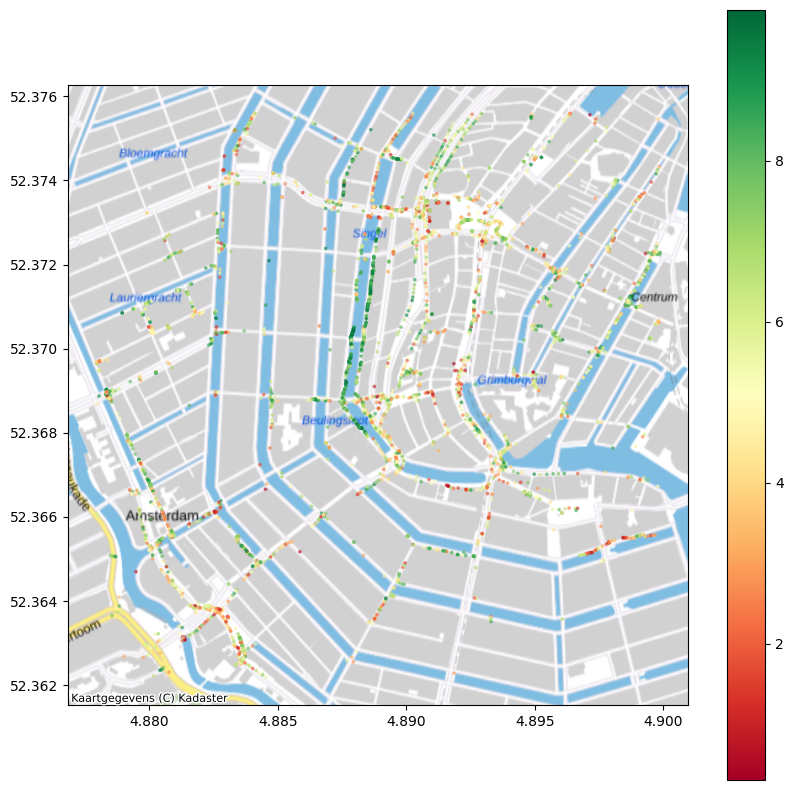

In [59]:
df = ams.to_pandas()
gdf = gpd.GeoDataFrame(df.Beautiful, geometry=gpd.points_from_xy(df.lon, df.lat))
gdf.set_crs("EPSG:4326", allow_override=True, inplace=True)
ax = gdf.plot(column='Beautiful', cmap='RdYlGn', legend=True, markersize=3, figsize=(10, 10), alpha=0.5)
contextily.add_basemap(ax, crs=gdf.crs, source=contextily.providers.nlmaps.standaard)


In [60]:
# city_pts = gp.GeoDataFrame(
#     df_city, geometry=gp.points_from_xy(df_city.lon, df_city.lat), crs="EPSG:4326"
# )

# city_day = city_pts[city_pts["lighting_condition"] == "day"]
# city_side = city_day[city_day["view_direction"] == "side"]

# city_day['building_fraction'] = city_day.apply(lambda x: x['Building']/x['Total'], axis=1)
# city_day['wall_fraction'] = city_day.apply(lambda x: x['Wall']/x['Total'], axis=1)
# city_walls = city_day[(city_day["wall_fraction"] > 0.15) | (city_day["building_fraction"] > 0.15)]
# city_walls.head(5)

Next, we will download images for the Amsterdam subset that we created above by using the images sources that we loaded into our workspace. We can download all the images corresponding to a data source in one go. However, the unified API of all image sources requires that the dataset contain two hardwired columns: `source` and `image_id`. This is a design choice to avoid having to handle potentially very different sources. Ibis makes it trivial to remap column names with the `select` method by providing a dictionary with the desired column names as keys and the existing columns that they map to as values.

In [61]:
src_table = ams.select({"source": "source", "image_id": "orig_id"})

Extract the source types in the table. A source must be supported ***and*** loaded in order to be recognised.

In [62]:
source_types = ws.get_source_types_from_table(src_table)
source_types

{<SourceType.KartaView: 'kartaview'>, <SourceType.Mapillary: 'mapillary'>}

Now we are ready to instruct the workspace manager to download the images. We can request only a sample of all the images (useful for initial prototyping and demonstrations like this one). Only missing images will be downloaded.

In [63]:
sample = ws.download_images(src_table, sample=10)

Streetscapes | 2025-04-29@13:53:45 | Reusing an existing Mapillary source, use the replace argument to override.


Peek into the sample.

In [64]:
sample

┏━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ source    ┃ image_id         ┃
┡━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ string    │ int64            │
├───────────┼──────────────────┤
│ Mapillary │  657548882028459 │
│ Mapillary │  775809403138862 │
│ Mapillary │  186048996678857 │
│ Mapillary │  121168543901269 │
│ Mapillary │  377414616852904 │
│ Mapillary │ 1214695849346328 │
│ Mapillary │ 3303092039946453 │
│ Mapillary │  806386039994923 │
│ Mapillary │ 3067873206760743 │
│ Mapillary │  304851231235433 │
└───────────┴──────────────────┘

Some of the images that we request might not exist any more on the image source. Figure out which images have been downloaded and which ones are missing.

In [65]:
existing, missing = ws.check_image_status(sample)
print(f"==[ existing: {[i.name for e in existing.values() for i in e]}")
print(f"==[ missing: {missing}")

Streetscapes | 2025-04-29@13:53:45 | Reusing an existing Mapillary source, use the replace argument to override.


==[ existing: ['377414616852904.jpeg', '3303092039946453.jpeg', '657548882028459.jpeg', '304851231235433.jpeg', '775809403138862.jpeg', '806386039994923.jpeg', '1214695849346328.jpeg', '3067873206760743.jpeg', '186048996678857.jpeg', '121168543901269.jpeg']
==[ missing: {<SourceType.Mapillary: 'mapillary'>: set()}
